# Interact with a JPL DE Ephemeris

Under the hood, `jorbit` leans heavily on the JPL DE ephemerides to account for perturbations from the planets and asteroids on a projectile's trajectory. Most of this happens behind the scenes when creating `Particle` objects, and users who aren't interested don't need to worry about it. However, if you ever want to actually interact with the JPL DE ephemerides (say, you want to know where the planets are at a given time and don't want to use a web service), you can do so using the `Ephemeris` class.

Some of the methods here resemble those in the excellent [jplephem](https://github.com/brandon-rhodes/python-jplephem/) package, and we do indeed use that package to help extract the data from the SPK files. However, after data loading, the rest of the class is pure JAX, which allows for nice vectorization and potentially GPU acceleration.

Finally, note that by default `jorbit` uses the DE440 ephemeris, though it also has built-in support for DE430. Since the DE430 files are not downloaded by default, the first time you use DE430 `jorbit` will first need to go and download the relevant .bsp files from JPL.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time

from jorbit import Ephemeris

The `Ephemeris` class is pretty simple: it takes four arguments, the first of which is currently only "default planets" or "default solar system", while the next two set the time span on the object. Shorter time spans require less memory, but even when loading the entire DE440 files it only takes up ~a GB of memory.

In [3]:
eph = Ephemeris(
    ssos="default planets",
    earliest_time=Time("1980-01-01"),
    latest_time=Time("2050-01-01"),
)

The last argument sets the DE ephemeris version, which can be either "440" (the default) or "430":

In [4]:
eph_430 = Ephemeris(
    ssos="default solar system",
    earliest_time=Time("1980-01-01"),
    latest_time=Time("2050-01-01"),
    de_ephemeris_version="430",
)

After this, the only method is `state`, which returns a dictionary with the position and velocity (defined as the derivative to the piecewise Chebyshev polynomial describing the position) of each body in the Ephemeris. Positions are always given in barycentric, ICRS coordinates.

In [5]:
data = eph.state(Time("2025-01-01"))
data

{'sun': {'x': <Quantity [-0.0057306 , -0.00457676, -0.00178861] AU>,
  'v': <Quantity [ 7.16079152e-06, -3.31716395e-06, -1.56644957e-06] AU / d>,
  'log_gm': Array(-8.12544774, dtype=float64, weak_type=True)},
 'mercury': {'x': <Quantity [-0.39302959, -0.16184669, -0.04566157] AU>,
  'v': <Quantity [ 0.00503283, -0.02171684, -0.01212185] AU / d>,
  'log_gm': Array(-23.73665301, dtype=float64, weak_type=True)},
 'venus': {'x': <Quantity [0.44767551, 0.51859088, 0.2049333 ] AU>,
  'v': <Quantity [-0.0157994 ,  0.01113419,  0.00600997] AU / d>,
  'log_gm': Array(-21.045753, dtype=float64, weak_type=True)},
 'earth': {'x': <Quantity [-0.18442782,  0.88263059,  0.38280716] AU>,
  'v': <Quantity [-0.01719753, -0.00293355, -0.00127197] AU / d>,
  'log_gm': Array(-20.84118348, dtype=float64, weak_type=True)},
 'moon': {'x': <Quantity [-0.18341098,  0.8805731 ,  0.38169173] AU>,
  'v': <Quantity [-0.01665894, -0.00270568, -0.00114904] AU / d>,
  'log_gm': Array(-25.23933649, dtype=float64, wea

We can also request multiple times at once:

In [6]:
data = eph.state(Time("2025-01-01") + np.arange(0, 365, 1) * u.day)

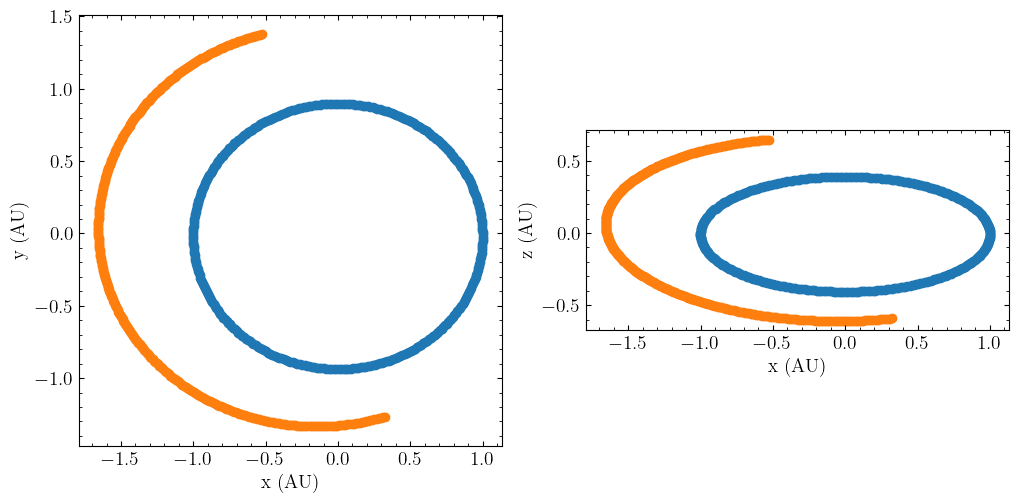

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

ax[0].scatter(data["earth"]["x"][:, 0], data["earth"]["x"][:, 1])
ax[0].scatter(data["mars"]["x"][:, 0], data["mars"]["x"][:, 1])
ax[0].set(aspect="equal", xlabel="x (AU)", ylabel="y (AU)")

ax[1].scatter(data["earth"]["x"][:, 0], data["earth"]["x"][:, 2])
ax[1].scatter(data["mars"]["x"][:, 0], data["mars"]["x"][:, 2])
ax[1].set(aspect="equal", xlabel="x (AU)", ylabel="z (AU)");

If you want to convert to ecliptic coordinates, you can either use something like Astropy, or one of `jorbit`'s core functions like so:

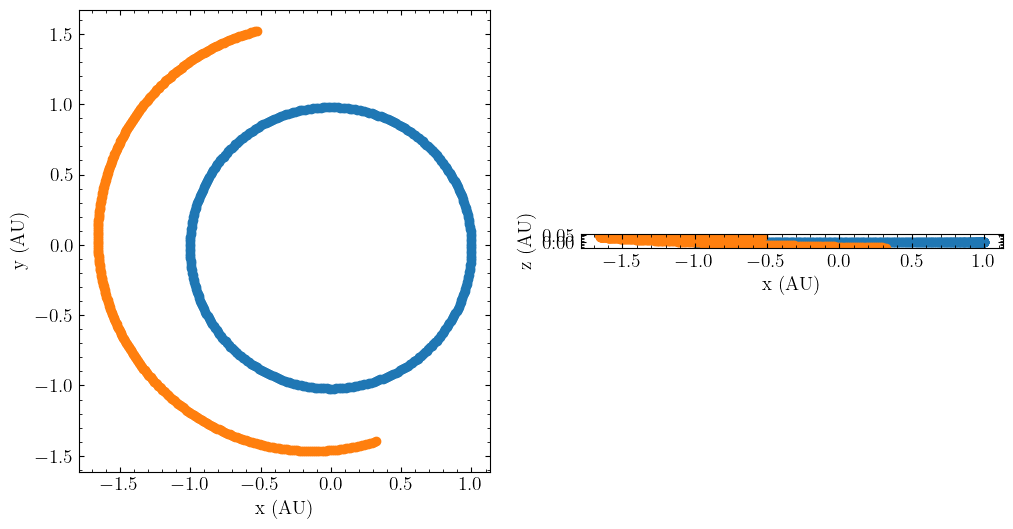

In [8]:
from jorbit.astrometry.transformations import icrs_to_horizons_ecliptic

ecliptic_earth = icrs_to_horizons_ecliptic(data["earth"]["x"].value) * u.AU
ecliptic_mars = icrs_to_horizons_ecliptic(data["mars"]["x"].value) * u.AU

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

ax[0].scatter(ecliptic_earth[:, 0], ecliptic_earth[:, 1])
ax[0].scatter(ecliptic_mars[:, 0], ecliptic_mars[:, 1])
ax[0].set(aspect="equal", xlabel="x (AU)", ylabel="y (AU)")

ax[1].scatter(ecliptic_earth[:, 0], ecliptic_earth[:, 2])
ax[1].scatter(ecliptic_mars[:, 0], ecliptic_mars[:, 2])
ax[1].set(aspect="equal", xlabel="x (AU)", ylabel="z (AU)");

Both the "default planets" and "default solar system" separate the Earth and Moon:

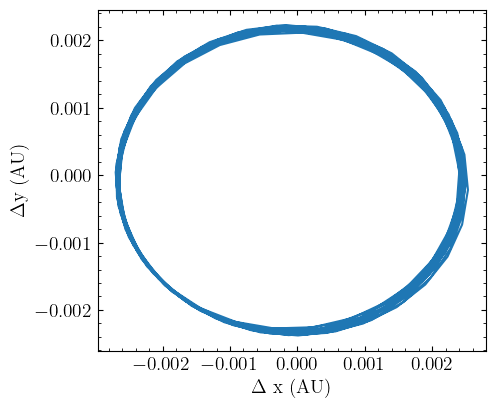

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(
    data["moon"]["x"][:, 0] - data["earth"]["x"][:, 0],
    data["moon"]["x"][:, 1] - data["earth"]["x"][:, 1],
)
ax.set(aspect="equal", xlabel=r"$\Delta$ x (AU)", ylabel=r"$\Delta$y (AU)");

Finally, we can also compare the differences between DE430 and DE440:

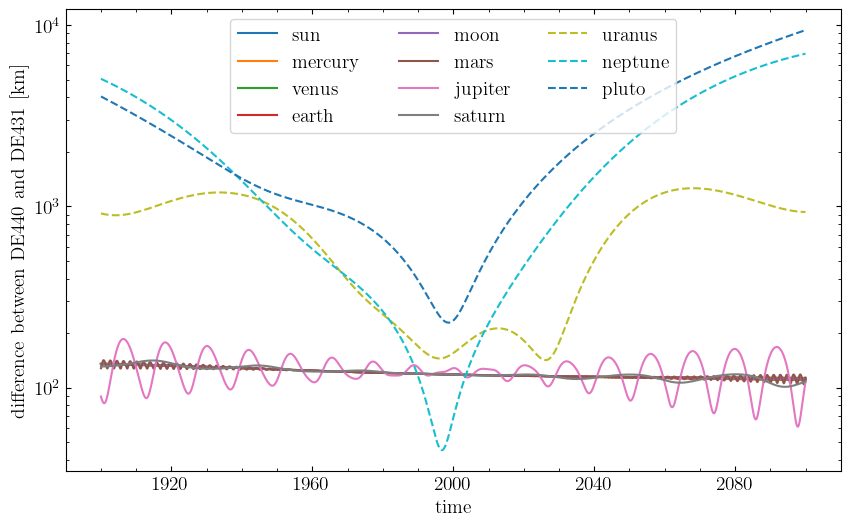

In [10]:
eph1 = Ephemeris(
    ssos="default planets",
    earliest_time=Time("1900-01-01"),
    latest_time=Time("2100-01-01"),
    de_ephemeris_version="440",
)

eph2 = Ephemeris(
    ssos="default planets",
    earliest_time=Time("1900-01-01"),
    latest_time=Time("2100-01-01"),
    de_ephemeris_version="430",
)

times = Time(
    np.linspace(Time("1900-01-01").jd, Time("2099-12-10").jd, 365 * 200),
    format="jd",
)

eph1_states = eph1.state(times)
eph2_states = eph2.state(times)


fig, ax = plt.subplots(figsize=(10, 6))
for planet in eph1_states.keys():
    if planet in ["uranus", "neptune", "pluto"]:
        ls = "--"
    else:
        ls = "-"
    delta = np.linalg.norm(eph1_states[planet]["x"] - eph2_states[planet]["x"], axis=1)
    ax.plot(times.utc.datetime, delta.to(u.km), label=planet, linestyle=ls)

ax.set(yscale="log", xlabel="time", ylabel="difference between DE440 and DE431 [km]")
ax.legend(ncols=3)

And the velocities, now with all of the asteroids as well:

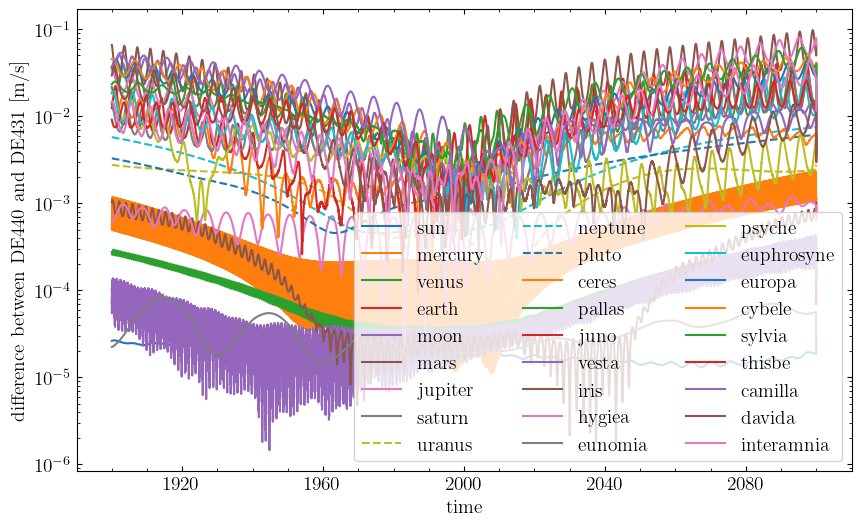

In [12]:
eph1 = Ephemeris(
    ssos="default solar system",
    earliest_time=Time("1900-01-01"),
    latest_time=Time("2100-01-01"),
    de_ephemeris_version="440",
)

eph2 = Ephemeris(
    ssos="default solar system",
    earliest_time=Time("1900-01-01"),
    latest_time=Time("2100-01-01"),
    de_ephemeris_version="430",
)

times = Time(
    np.linspace(Time("1900-01-01").jd, Time("2100-01-01").jd, 365 * 200),
    format="jd",
)

eph1_states = eph1.state(times)
eph2_states = eph2.state(times)


fig, ax = plt.subplots(figsize=(10, 6))

for planet in eph1_states.keys():
    if planet in ["uranus", "neptune", "pluto"]:
        ls = "--"
    else:
        ls = "-"
    delta = np.linalg.norm(eph1_states[planet]["v"] - eph2_states[planet]["v"], axis=1)
    ax.plot(times.utc.datetime, delta.to(u.m / u.s), label=planet, linestyle=ls)

ax.set(yscale="log", xlabel="time", ylabel="difference between DE440 and DE431 [m/s]")
ax.legend(ncols=3)